# 💸 IA pour la prédiction des faillites d'entreprises

In [78]:
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN


# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve


# models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


# tuning
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import pickle

In [100]:
# read data
df = pd.read_csv('data/df.csv')

<b>Robust Scaler / SMOTE ENN / Random Forest</b>

J'utilise ici Smote with ENN : SMOTE est d'abord appliqué pour oversampler, puis en utilisant ENN, les points de données sur la frontière sont supprimés pour augmenter la séparation des deux classes.

<img src = "img/smote_enn.png" width="400">

In [101]:
# define X & y
X = df.drop(['Bankrupt'], axis=1)
y = df['Bankrupt']

In [102]:
# standardizing the features (scaling)
X_std = RobustScaler().fit_transform(X)

In [103]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.3)

In [104]:
smt = SMOTEENN(random_state=42)

X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

# concat in new dataframe
df_smt = pd.concat([pd.DataFrame(y_train_smt), pd.DataFrame(X_train_smt)], axis=1)

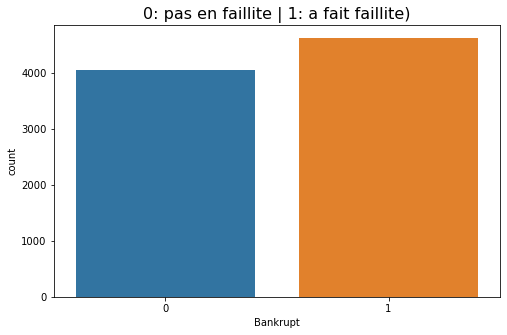

In [105]:
# target : "Bankrupt" after SMOTE ENN
plt.figure(figsize = (8,5))
plt.title('0: pas en faillite | 1: a fait faillite)', fontsize=16)
sns.countplot(x="Bankrupt", data=df_smt)
plt.show()

In [106]:
df_smt['Bankrupt'].value_counts()

1    4623
0    4051
Name: Bankrupt, dtype: int64

In [107]:
# Random Forest Classifier with GrindSearchCV

# model
model_rf3 = RandomForestClassifier()

# param grindsearchcv
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [2, 6, 10]
             }

#gridsearch cv
grid = GridSearchCV(model_rf3, param_grid=param_grid, cv=5, scoring='accuracy',verbose=3)

#fit
grid.fit(X_train_smt, y_train_smt)

# score & best parameters
print(grid.best_score_)
print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...................max_depth=2, n_estimators=50; total time=   0.2s
[CV 2/5] END ...................max_depth=2, n_estimators=50; total time=   0.2s
[CV 3/5] END ...................max_depth=2, n_estimators=50; total time=   0.2s
[CV 4/5] END ...................max_depth=2, n_estimators=50; total time=   0.2s
[CV 5/5] END ...................max_depth=2, n_estimators=50; total time=   0.2s
[CV 1/5] END ..................max_depth=2, n_estimators=100; total time=   0.5s
[CV 2/5] END ..................max_depth=2, n_estimators=100; total time=   0.5s
[CV 3/5] END ..................max_depth=2, n_estimators=100; total time=   0.6s
[CV 4/5] END ..................max_depth=2, n_estimators=100; total time=   0.6s
[CV 5/5] END ..................max_depth=2, n_estimators=100; total time=   0.6s
[CV 1/5] END ..................max_depth=2, n_estimators=150; total time=   0.9s
[CV 2/5] END ..................max_depth=2, n_est

In [111]:
model = grid.best_estimator_
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)

# score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95      1975
           1       0.24      0.83      0.37        71

    accuracy                           0.90      2046
   macro avg       0.61      0.87      0.66      2046
weighted avg       0.97      0.90      0.93      2046



In [112]:
import pickle

with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

<AxesSubplot:>

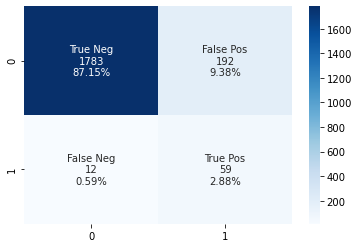

In [109]:
# confusion matrix
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

[0.         0.09721519 1.        ] [0.         0.83098592 1.        ]
86.688536280977


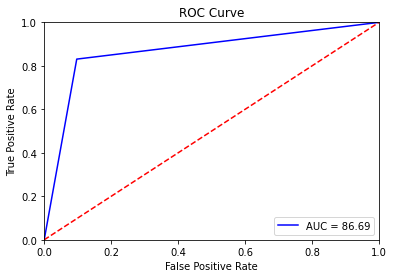

In [110]:
from sklearn.metrics import roc_curve,auc
fp, tp, thresholds=roc_curve(y_test,y_pred,pos_label=1)
print(fp, tp)
AUC=auc(fp, tp)*100
print(AUC)

#tracer tp en fonction de fp
import matplotlib.pyplot as plt
plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
plt.title('ROC Curve')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

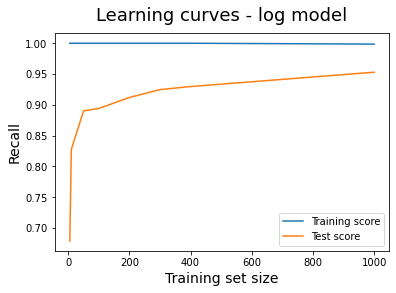

In [114]:
# learning curve

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                          X = X_train_smt,
                                          y = y_train_smt,
                                          train_sizes = [5,10,50,100,200,300,400,1000],
                                          cv = 5,
                                          shuffle = True,
                                          random_state=3)

# take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plot the learning curves
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves - log model', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

# Pickle

In [115]:
my_model = pickle.load(open("model.pkl","rb"))
my_model.score(X_test, y_test)

0.9002932551319648